# DLFL25U: Introduction to Deep Learning

**Name:** Hailemariam Mersha


**Instructions:**

In this notebook, you will be asked to write code and answer questions.  
Place all responses under the **Solution** headers.

---

This fourth assignment is aimed at training fully connected neural networks and understanding their behaviour.

In [41]:
import numpy as np
from math import log
import matplotlib.pyplot as plt

SEED = 31

np.random.seed(SEED)

## Cloning the micrograd repo

Before we start, we need to clone the micrograd repository. This repository contains the original code for the micrograd library, which we will use to build our neural network.

In order to do so you need install the micrograd package by running the following cell

In [42]:
!pip install micrograd

## 1. Missing Ingredients

The original implementation of the Micrograd library by Andrej Karpathy is missing some important components that we need to build a neural network. In this first exercise you are asked to implement these components. Some of them have already been introduced in the lectures, while others are new.

### Functions and operators

The components you should already be familiar with are:

- Exponential: $\exp (x)$
- Logarithm: $\log(x)$
- Sigmoid: $\sigma(x) = (1 + \exp (-x))^{-1}$

These components were introduced to solve the **Linear Regression** and **Binary Classification** problems. Below is a new class, `Value`, derived from the original one, in which you are asked to implement these missing methods.

Additionally you will implement the following components as methods of the `Value` class:

- Softplus: $\log(1 + e^x)$

Then, externally to the `Value` class, you will implement the following functions:

- Softmax: $\text{softmax}(\boldsymbol{x}) = \log \left( \sum_i \exp(x_i) \right)$
- Softargmax: $\text{softargmax}(\boldsymbol{x}) = \frac{\exp(\boldsymbol{x})}{\sum_i \exp(x_i)}$

In [63]:
from micrograd.engine import Value as OldValue

class Value(OldValue):
    def __init__(self, data, _children=(), _op='', label=''):
        OldValue.__init__(self, data)
        self._prev = set(_children) if _children else set()
        self._op = _op
        self.label = label

    def exp(self):
        out = Value(np.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.grad * out.data #
        out._backward = _backward
        return out

    def log(self):
        eps = 1e-12
        out = Value(np.log(self.data + eps), (self,), 'log')
        def _backward():
            self.grad += out.grad * (1 / (self.data + eps))
        out._backward = _backward
        return out

    def sigmoid(self):
        s = 1 / (1 + np.exp(-self.data))
        out = Value(s, (self,), 'sigmoid')
        def _backward():
            self.grad += out.grad * s * (1 - s)
        out._backward = _backward
        return out

    def softplus(self):
        val = np.log1p(np.exp(self.data))  # numerically stable
        out = Value(val, (self,), 'softplus')
        def _backward():
            self.grad += out.grad * (1 / (1 + np.exp(-self.data)))  # derivative = sigmoid(x)
        out._backward = _backward
        return out




In [44]:
def softmax(x_list):
    x = np.array(x_list)
    return np.log(np.sum(np.exp(x)))

def softargmax(x_list):
    x = np.array(x_list)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

**WARNING**

*The following cell must not be modified and should be run only after implementing the `Value` class. Removing or altering this cell may cause issues, as subsequent cells depend on this class implementation.*

In [45]:
OldValue.__new__ = staticmethod(lambda *args, **kwargs: object.__new__(Value))

### Loss functions

Additionally, we would like to define some loss functions that are commonly used in neural networks. These are:

- Mean Squared Error:
    $$L_{\text{MSE}}(\boldsymbol{w}, x, y) = (y - \boldsymbol{w}^\top \boldsymbol{f}(x))^2$$
- Binary Cross Entropy:
$$
\begin{align*}
L_{\text{BCE}}(\boldsymbol{w}, x, y) &= y \: \text{softplus}(-\boldsymbol{w}^\top \boldsymbol{f}(x)) + (1-y) \: \text{softplus}(\boldsymbol{w}^\top \boldsymbol{f}(x)) \\
&= \text{softplus}( -y' \boldsymbol{w}^\top \boldsymbol{f}(x)), \quad \text{where} \:\quad y' = 2y - 1
\end{align*}
$$
- (Multiclass) Cross Entropy:
$$
\begin{align*}
L_{\text{CE}}(\boldsymbol{w},x,y) &= \log \sum_{k=1}^{K} \exp(\boldsymbol{w}_k^{\top} \boldsymbol{f}(x)) -\boldsymbol{w}_y^{\top} \boldsymbol{f}(x) \\
&= \text{softmax}(\boldsymbol{W} \boldsymbol{f}(x)) -\boldsymbol{w}_y^{\top} \boldsymbol{f}(x)
\end{align*}
$$

In order to do so, please implement the following methods in the `Loss` class:

- `mse`
- `bce`
- `ce`

#### Brief explanation of the `Loss` class

Each *per-sample* loss function is implemented as a static method of the class. To create an instance of the class, you need to pass the *per-sample* loss function as an argument to the constructor.

```python
loss = Loss(Loss.mse)
```

The `global_loss` method is used to compute the average loss over all samples. Invoking the object directly, as defined in `__call__`, will compute the *global* loss.

```python
loss = Loss(Loss.mse)
global_loss_value = loss(Y, Y_pred)
```

In [46]:
class Loss:

    def __init__(self, loss_function):
        self.loss_function = loss_function

    def __call__(self, y, y_pred):
        return self.global_loss(y, y_pred)

    def sample_loss(self, y, y_pred):
        y = Value(y) if not isinstance(y, Value) else y
        y_pred = Value(y_pred) if not isinstance(y_pred, Value) else y_pred
        return self.loss_function(y, y_pred)

    def global_loss(self, Y, Y_pred):
        losses = [ self.sample_loss(y, y_pred) for y, y_pred in zip(Y, Y_pred) ]
        return sum(losses) / len(Y)

    @staticmethod
    def mse(y, y_pred):
        return (y - y_pred) ** 2

    @staticmethod
    def bce(y, y_pred):
        y_ = 2 * y - 1       # convert {0,1} → {-1,1}
        return (-y_ * y_pred).softplus()

    @staticmethod
    def ce(y, y_pred):
        # y_pred is a list/array of raw scores for each class
        # y is the correct class index (integer)
        sm = softmax([v.data if isinstance(v, Value) else v for v in y_pred])
        return Value(sm) - y_pred[int(y)]

## 2. Regression

Now that we have all the necessary components, we start by implementing a neural network for regression. The goal is to approximate the following functions:

- $y=x^2$
- $y=\sin(x)$

For each function:

- Generate 400 samples in the range $[-5, 5]$, then add some Gaussian noise using the `np.random.normal` function with zero mean, $\mu=0$, and a standard deviation of $\sigma = 0.3$. This is your training set. Repeat the process for the test set.
<!-- $$
\begin{align*}
    \mathcal{D} &= \{ (x_i, y_i) \mid x_i \in [-5, 5] \cap \mathbb{R}, y_i = f(x_i) + \varepsilon_i \} \\
    \varepsilon_i &\sim \mathcal{N}(0, 0.3)
\end{align*}
$$ -->

- Use the a fully connected neural network (unfortunately named `MLP` by Karpathy) with the ReLU activation function. Train the network until convergence or until you find the performance satisfactory. After training, plot the loss evolution and analyze it. Does the loss always decrease in the same manner? Consider whether different regimes appear while the loss is decreasing.
**Tip**: *If so, save the model at the epoch where the learning behavior changes and plot the predictions against the ground truth. This will help you better understand what is happening.*

- Using the trained model, compute the predictions for both the training set and test set and compute the loss. Then plot the predictions against the ground truth for the test set.

In this exercise, you are free to experiment by varying both the number of hidden layers and the number of neurons in each layer. Choose the architecture that you think better approximates the functions keeping in mind that, because the library is not optimized, training may take a long time.

---

### **Some Tips on the `MLP` Class by Karpathy**

The `MLP` class is a simple implementation of a fully connected neural network, often incorrectly referred to as a Multi-Layer Perceptron (MLP), since perceptrons use the heavisde activation function, which derivative is zero almost everywhere.

The constructor of the `MLP` class takes two inputs:
- `nin`: the number of input neurons
- `nouts`: a list specifying the number of neurons in each hidden layer and the output layer.

If you want to create a network with an input dimension of 3, two hidden layers of 10 neurons each, and an output layer of 1 neuron, you should instantiate the class as follows:

```python
net = MLP(3, [10, 10, 1])
```

Moreover, the `__call__` method of the class takes the input data and returns the network's output (the prediction). It expects the input data to be a list of either `Value` objects or numbers.
As a consequence, even if your inputs has dimension 1, you should still pass it as a list with just one item:

```python
x = [2.0]
ỹ = net(x)
```

If your input dimension is 2 and you have 3 data points, computing the predictions will look like this:

```python
X = [
    [Value(1.0), Value(2.0)],
    [Value(3.0), Value(4.0)],
    [Value(5.0), Value(6.0)]
]
Ỹ = [net(x) for x in X]
```

Finally, the type of the output depends on the output size: if the output size is 1, the output will just be a `Value` object, if the output size is greater than 1, the output will be a list of `Value` objects.

---


### How to **Train** Your Neural Network

Before training the neural network, some training *hyperparameters* must be defined. In our case, these are:

- Which optimizer to use. In this case, we will use the **Stochastic Gradient Descent (SGD)** optimizer.
    SGD updates the parameters using the gradient computed from *a single sample*. This makes it much faster and often better for generalization, but the updates are noisier. Noisy updates can help the algorithm escape local minima.

    Example in Python:
    ```python
    # Stochastic Gradient Descent (SGD)
    for epoch in range(n_epochs):
        for x, y in zip(X, Y):  # Iterate over individual samples
            y_pred = model([Value(xi) for xi in x])
            loss_val = loss(y, y_pred)
            model.zero_grad()
            loss_val.backward()
            for p in model.parameters():
                p.data -= learning_rate * p.grad.data
    ```

- `learning_rate`: the step size of the gradient descent algorithm.  
- `n_epochs`: the number of epochs, i.e., the number of times the network will see the entire dataset.

The process of training a neural network can be summarized as follows:

- **Forward Pass**:
    Compute the output of the network given the input data:
    ```python
        y_pred = model([xi for xi in x])
    ```
- **Loss Computation**:
    Compute the loss function:
    ```python
       loss_value = loss(y, y_pred)
    ```

- **Zero out the gradients**:
    Before computing the gradients, it is necessary to zero out the gradients of the parameters:
    ```python
        model.zero_grad()
    ```

- **Backward Pass**
    Compute the gradients of the loss function with respect to the parameters:
    ```python
        loss_value.backward()
    ```

- **Optimizer Step**
    Update the parameters using the gradients:
    ```python
        for p in model.parameters():
            p.data -= learning_rate * p.grad.data
    ```


In [47]:
from micrograd.nn import MLP as FCNN

### 2.1 $y=x^2$

In [48]:
g = lambda x: x**2

#### Data Generation

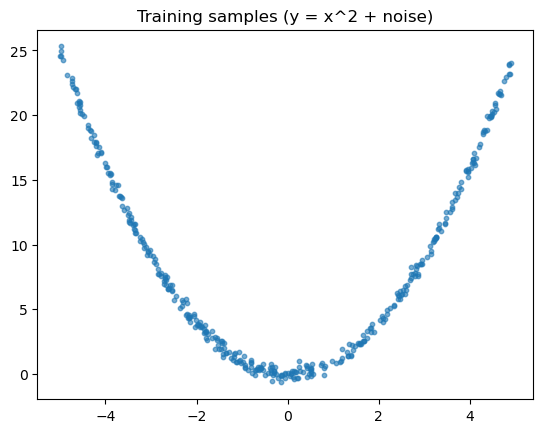

In [49]:
SEED = 31
np.random.seed(SEED)
N = 400
sigma = 0.3   # noise std

def generate_data(func, N=400):
    X = np.random.uniform(-5, 5, N)
    y = func(X) + np.random.normal(0, sigma, N)
    return X.reshape(-1, 1), y.reshape(-1, 1)
g = lambda x: x**2
X_train, y_train = generate_data(g)
X_test, y_test = generate_data(g)

plt.scatter(X_train, y_train, s=10, alpha=0.6)
plt.title("Training samples (y = x^2 + noise)")
plt.show()


#### Training

In [50]:
from micrograd.engine import Value

net = FCNN(1, [16, 16, 1])
loss_fn = Loss(Loss.mse)

learning_rate = 1e-3
n_epochs = 100

train_losses = []

for epoch in range(n_epochs):
    total_loss = 0.0

    for xi, yi in zip(X_train, y_train):
        # forward
        y_pred = net([Value(float(xi))])
        loss = loss_fn.sample_loss(Value(float(yi)), y_pred)

        # backward
        net.zero_grad()
        loss.backward()

        # SGD step
        for p in net.parameters():
            p.data -= learning_rate * p.grad

        total_loss += loss.data

    avg_loss = total_loss / len(X_train)
    train_losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Avg Train Loss: {avg_loss:.6f}")


/var/folders/bg/rr1v108n1851vd88zm17s0280000gn/T/ipykernel_8932/1337159096.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = net([Value(float(xi))])
/var/folders/bg/rr1v108n1851vd88zm17s0280000gn/T/ipykernel_8932/1337159096.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss = loss_fn.sample_loss(Value(float(yi)), y_pred)


Epoch   0 | Avg Train Loss: 9.692716
Epoch  10 | Avg Train Loss: 0.440394
Epoch  20 | Avg Train Loss: 0.291101
Epoch  30 | Avg Train Loss: 0.249714
Epoch  40 | Avg Train Loss: 0.225865
Epoch  50 | Avg Train Loss: 0.215418
Epoch  60 | Avg Train Loss: 0.207220
Epoch  70 | Avg Train Loss: 0.202452
Epoch  80 | Avg Train Loss: 0.196874
Epoch  90 | Avg Train Loss: 0.193815


#### Prediction

/var/folders/bg/rr1v108n1851vd88zm17s0280000gn/T/ipykernel_8932/672554752.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_pred = [net([Value(float(x))]).data for x in X_test]


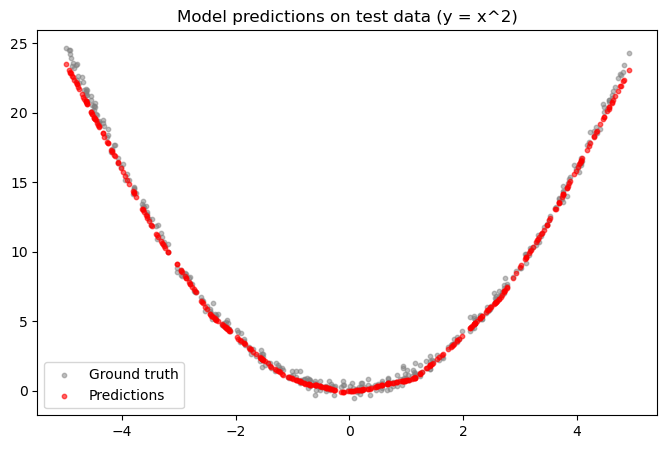

Test loss: 0.19773451010633722


In [51]:
# Predictions on test data
Y_pred = [net([Value(float(x))]).data for x in X_test]

plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, s=10, color='gray', alpha=0.5, label="Ground truth")
plt.scatter(X_test, Y_pred, s=10, color='red', alpha=0.6, label="Predictions")
plt.legend()
plt.title("Model predictions on test data (y = x^2)")
plt.show()

# Compute test loss
test_loss = np.mean([(y - yhat)**2 for y, yhat in zip(y_test, Y_pred)])
print("Test loss:", test_loss)


### 2.2 $y=\sin(x)$

In [52]:
g = lambda x: np.sin(x)

#### Data Generation

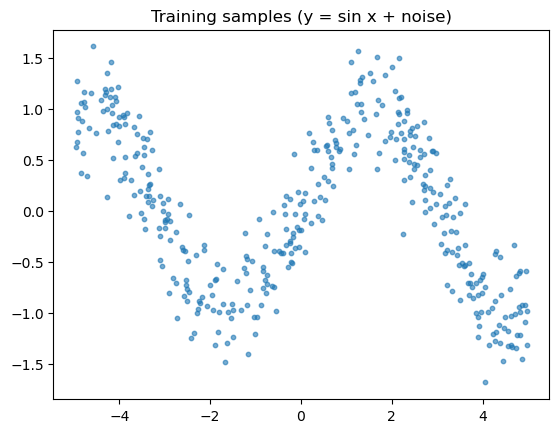

In [53]:
# CODE HERE
g = lambda x: np.sin(x)
X_train, y_train = generate_data(g)
X_test, y_test = generate_data(g)

plt.scatter(X_train, y_train, s=10, alpha=0.6)
plt.title("Training samples (y = sin x + noise)")
plt.show()



#### Training

In [54]:
from micrograd.engine import Value

net = FCNN(1, [16, 16, 1])
loss_fn = Loss(Loss.mse)

learning_rate = 1e-3
n_epochs = 100

train_losses = []

for epoch in range(n_epochs):
    total_loss = 0.0

    for xi, yi in zip(X_train, y_train):
        # forward
        y_pred = net([Value(float(xi))])
        loss = loss_fn.sample_loss(Value(float(yi)), y_pred)

        # backward
        net.zero_grad()
        loss.backward()

        # SGD step
        for p in net.parameters():
            p.data -= learning_rate * p.grad

        total_loss += loss.data

    avg_loss = total_loss / len(X_train)
    train_losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Avg Train Loss: {avg_loss:.6f}")


/var/folders/bg/rr1v108n1851vd88zm17s0280000gn/T/ipykernel_8932/1337159096.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = net([Value(float(xi))])
/var/folders/bg/rr1v108n1851vd88zm17s0280000gn/T/ipykernel_8932/1337159096.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss = loss_fn.sample_loss(Value(float(yi)), y_pred)


Epoch   0 | Avg Train Loss: 0.852978
Epoch  10 | Avg Train Loss: 0.148324
Epoch  20 | Avg Train Loss: 0.130030
Epoch  30 | Avg Train Loss: 0.123911
Epoch  40 | Avg Train Loss: 0.120589
Epoch  50 | Avg Train Loss: 0.117620
Epoch  60 | Avg Train Loss: 0.115959
Epoch  70 | Avg Train Loss: 0.113906
Epoch  80 | Avg Train Loss: 0.112376
Epoch  90 | Avg Train Loss: 0.111159


#### Prediction

/var/folders/bg/rr1v108n1851vd88zm17s0280000gn/T/ipykernel_8932/711944567.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_pred = [net([Value(float(x))]).data for x in X_test]


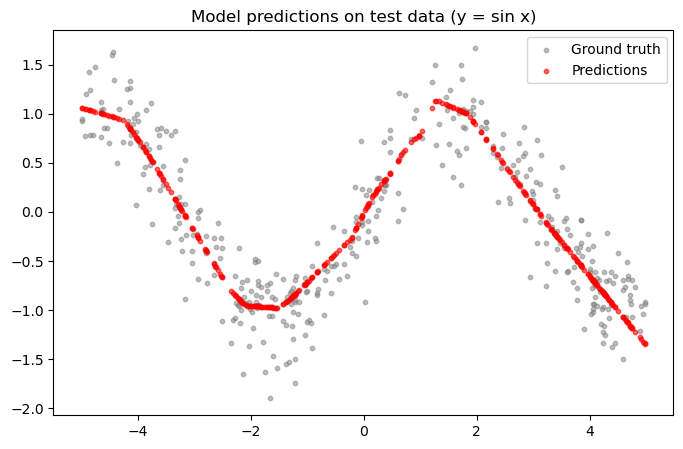

Test loss: 0.10362243324180623


In [55]:

# Predictions on test data
Y_pred = [net([Value(float(x))]).data for x in X_test]

plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, s=10, color='gray', alpha=0.5, label="Ground truth")
plt.scatter(X_test, Y_pred, s=10, color='red', alpha=0.6, label="Predictions")
plt.legend()
plt.title("Model predictions on test data (y = sin x)")
plt.show()

# Compute test loss
test_loss = np.mean([(y - yhat)**2 for y, yhat in zip(y_test, Y_pred)])
print("Test loss:", test_loss)

## Binary Classification

In the second task you are asked to complete is to implement a neural network for binary classification on a non-linearly separable dataset.

### Dataset Generation

The first step is to generate a dataset. We will use the `make_moons` function from the `sklearn.datasets` module to generate a dataset with two classes. You should generate 300 samples with a noise parameter of 0.1. Then plot the dataset using the `matplotlib` library.

In [56]:
from sklearn.datasets import make_moons

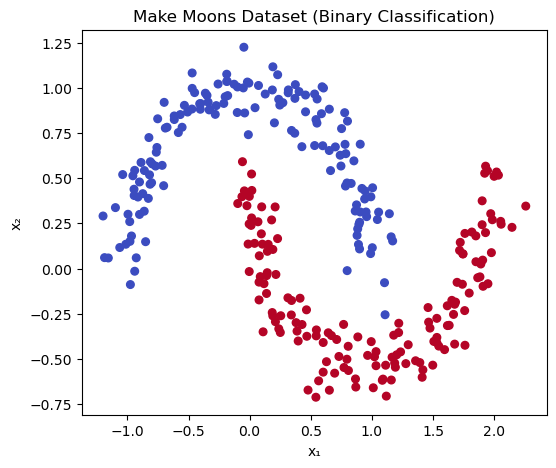

In [57]:
X, y = make_moons(n_samples=300, noise=0.1, random_state=0)

# Visualize
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=30)
plt.title("Make Moons Dataset (Binary Classification)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()

### Model Definition

Next, you should define a Fully Connected Neural Network to perform the binary classification. You are free to choose the number of hidden layers and neurons in each layer. Be aware that this implementation is not optimized for performance, so you should keep the number of neurons and layers small while achieving decent performance.

In [58]:
from micrograd.nn import MLP as FCNN

In [59]:
#  2 inputs → 2 hidden layers → 1 output neuron
net = FCNN(2, [16, 16, 1])

# Loss function: Binary Cross Entropy
loss_fn = Loss(Loss.bce)
# CODE HERE
learning_rate = 0.05
n_epochs = 100
train_losses = []

### Training

Now it is time to train the model. You should train the model until it converges or until a decent performance is reached. Use an appropriate loss function using the `Loss` class. Save the loss values in a list, we will use them later.

In [64]:
for epoch in range(n_epochs):
    epoch_loss = 0.0

    for xi, yi in zip(X, y):
        # Forward pass (wrap inputs as Value objects)
        inputs = [Value(float(v)) for v in xi]
        y_pred = net(inputs)            # one Value output
        loss = loss_fn.sample_loss(Value(float(yi)), y_pred)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Gradient update
        for p in net.parameters():
            p.data -= learning_rate * p.grad

        epoch_loss += loss.data

    avg_loss = epoch_loss / len(X)
    train_losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Average loss: {avg_loss:.4f}")


Epoch   0 | Average loss: 0.2985
Epoch  10 | Average loss: 0.0337
Epoch  20 | Average loss: 0.0207
Epoch  30 | Average loss: 0.0263
Epoch  40 | Average loss: 0.0084
Epoch  50 | Average loss: 0.0278
Epoch  60 | Average loss: 0.0016
Epoch  70 | Average loss: 0.0012
Epoch  80 | Average loss: 0.0009
Epoch  90 | Average loss: 0.0007


### Evaluation

In this last part we want to evaluate how the loss changed during the training process and how is the performance of the model we obtained.

- Plot the loss evolution during the training process
- Print the loss value achieved at the end of the training process
- Compute the accuracy of the model on the training set
- Plot the predictions of the model on the training set. Do they resemble the dataset?
- On the same plot, plot the decision boundary of the model.

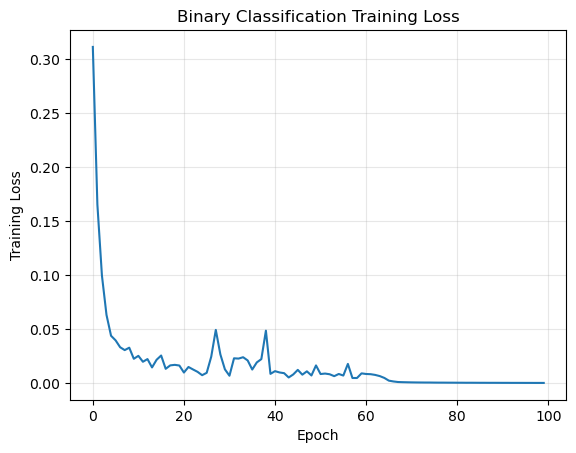

In [ ]:
# CODE HERE
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Binary Classification Training Loss")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
def predict(x):
    out = net([Value(float(v)) for v in x])
    return 1 if out.data > 0 else 0  # threshold at 0 (since BCE used logits)

y_pred = np.array([predict(xi) for xi in X])
accuracy = np.mean(y_pred == y)
print(f"Training Accuracy: {accuracy*100:.2f}%")


Training Accuracy: 100.00%


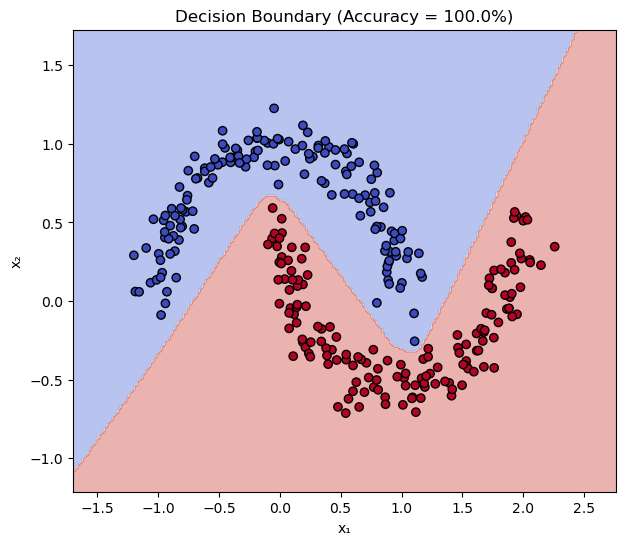

In [ ]:
# Decision boundary grid
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = np.array([predict(pt) for pt in grid])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title(f"Decision Boundary (Accuracy = {accuracy*100:.1f}%)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()
